# Importing / Downloading necessary modules

In [ ]:
!pip install -q snscrape==0.3.4
!pip install tweet-preprocessor
!pip install ekphrasis
!pip install pyLDAvis
!pip install --upgrade spacy

In [2]:
!pip install -q gensim 

In [5]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import nltk
import os
import gensim
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import pickle
nltk.downloader.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import preprocessor as p
from gensim.parsing.preprocessing import remove_stopwords
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
from nltk import FreqDist
from ekphrasis.classes.segmenter import Segmenter
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from gensim.models.ldamulticore import LdaMulticore
import spacy
import en_core_web_sm
import random

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Collection of Tweets
Release Date of "DNA": 2017-09-18

Timeframe:
1. A week before the release 2017-09-11 to 2017-09-17
2. Week of the release 2017-09-18 to 2017-09-24
3. A week after the release 2017-09-25 to 2017-10-01
4. Two weeks after the release 2017-10-02 to 2017-10-08

In [7]:
# Preprocessing Functions

def remove_timezone(dt):
  return dt.replace(tzinfo = None)

nlp = en_core_web_sm.load(disable=['parser', 'ner'])

def get_lemmas(text):
  lemmas = []
  doc = nlp(text)
  for token in doc:
    if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
      lemmas.append(token.lemma_)
    
  return lemmas

stop_words = stopwords.words('english')

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


In [19]:
from google.colab import files

wb_csv = pd.DataFrame(itertools.islice(
    sntwitter.TwitterSearchScraper(
    'DNA AND BTS AND #bts AND #dna OR billboard since:2017-09-11 until:2017-09-17 lang:"en"').get_items(), 1000))

wb_csv = wb_csv.drop(["id", "outlinks", "outlinksss", "tcooutlinks", "tcooutlinksss"], axis = 1)
wb_csv.to_csv("wb_csv.csv", header = True)
files.download("wb_csv.csv")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Week Before the Release

### Collecting the Tweets and Preprocessing the Tweets to clean

In [21]:
# A Week before the release
# Did not include #streaming since the song is not yet released
random.seed(10)

df_weekbefore = pd.DataFrame(itertools.islice(
    sntwitter.TwitterSearchScraper(
    'DNA AND BTS AND #bts AND #dna OR billboard since:2017-09-11 until:2017-09-17 lang:"en"').get_items(), 1000))

df_weekbefore = df_weekbefore.drop(["id", "outlinks", "outlinksss", "tcooutlinks", "tcooutlinksss"], axis = 1)

df_weekbefore['Id'] = range(1, len(df_weekbefore) + 1)
first_column = df_weekbefore.pop('Id')
df_weekbefore.insert(0, 'Id', first_column)

# Remove Timezones and convert date to pd format

df_weekbefore['date'] = df_weekbefore['date'].apply(remove_timezone)
df_weekbefore['date'] = pd.to_datetime(df_weekbefore['date'])

#Preprocessing Tweets

df_weekbefore['text'] = df_weekbefore.content.apply(lambda x: re.sub(r'https?:\/\/\S+', ' ', x))
df_weekbefore['text'] = df_weekbefore.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", ' ', x))
df_weekbefore['text'] = df_weekbefore.text.apply(lambda x: re.sub(r"\b's\b", ' ', x))
df_weekbefore['text'] = df_weekbefore.text.apply(lambda x: re.sub(r'{link}', ' ', x))
df_weekbefore['text'] = df_weekbefore.text.apply(lambda x: re.sub(r"\[video\]", ' ', x))
df_weekbefore['text'] = df_weekbefore.text.apply(lambda x: re.sub(r'&[a-z]+;', ' ', x))
df_weekbefore['text'] = df_weekbefore.text.apply(lambda x: re.sub(r'\s*@\w+', ' ', x))
df_weekbefore['text'] = df_weekbefore.text.apply(lambda x: re.sub(r'[^\w]', ' ', x))
df_weekbefore['text'] = df_weekbefore.text.apply(lambda x: re.sub(r'\n', ' ', x))
df_weekbefore['text'] = df_weekbefore.text.apply(lambda x: re.sub(r'[^a-zA-Z0-9]+', ' ', x))


df_weekbefore['tokens'] = df_weekbefore['content'].apply(tknzr.tokenize)

#List all hastags added to a new column as a new feature 'hashtag'
df_weekbefore['hashtag'] = df_weekbefore['content'].apply(lambda x: 
                                    re.findall(r"#(\w+)", x))

df_weekbefore['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df_weekbefore['tokens']]
df_weekbefore['tokens_back_to_text'] = df_weekbefore['tokens_back_to_text'].str.replace(r'\s*@\w+', '', regex=True)
df_weekbefore['tokens_back_to_text'] = df_weekbefore['tokens_back_to_text'].str.replace(r"\b's\b", ' ', regex = True)
df_weekbefore['tokens_back_to_text'] = df_weekbefore['tokens_back_to_text'].str.replace(r'[^\w]', ' ', regex = True)
df_weekbefore['tokens_back_to_text'] = df_weekbefore['tokens_back_to_text'].str.replace(r'[^a-zA-Z0-9]+', ' ', regex = True)

#Lemmatization
df_weekbefore['lemmas'] = df_weekbefore['tokens_back_to_text'].apply(get_lemmas)

df_weekbefore['lemmas_to_text'] = [' '.join(map(str, l)) for l in df_weekbefore['lemmas']]
df_weekbefore['lemma_tokens'] = df_weekbefore['lemmas_to_text'].apply(tknzr.tokenize)

df_weekbefore.head()

Id                                                url                date  \
0   1  https://twitter.com/PsychicBoySuga/status/9092... 2017-09-16 23:53:57   
1   2  https://twitter.com/VickyJimin/status/90920291... 2017-09-16 23:50:42   
2   3  https://twitter.com/king_kimyohan/status/90920... 2017-09-16 23:45:42   
3   4  https://twitter.com/jingyeokebts/status/909200... 2017-09-16 23:42:01   
4   5  https://twitter.com/rnikiyaa/status/9091995086... 2017-09-16 23:37:09   

                                             content        username  \
0  Online Promotion for @BTS_twt #LOVE_YOURSELF #...  PsychicBoySuga   
1  #BTSALBUM1DAY \n  #DNA \n\n/   are you ready\n...      VickyJimin   
2  What's DNA ? \nBIGHIT: Do not answer \nMe: Die...   king_kimyohan   
3  Two words, six letters, legendary and taking t...    jingyeokebts   
4  Sorry I forgot if there date 17 😅 @BTS_twt #BT...        rnikiyaa   

                                                text  \
0        Online Promotion for LOVE YOURSELF DNA BTS    
1     BTSALBUM1DAY DNA are you ready lets party BTS    
2  What DNA BIGHIT Do not answer Me Die now antis...   
3  Two words six letters legendary and taking the...   
4  Sorry I forgot if there date 17 BTS HER DNA LO...   

                                              tokens  \
0  [Online, Promotion, for, @BTS_twt, #LOVE_YOURS...   
1  [#BTSALBUM1DAY, #DNA, /, are, you, ready, lets...   
2  [What's, DNA, ?, BIGHIT, :, Do, not, answer, M...   
3  [Two, words, ,, six, letters, ,, legendary, an...   
4  [Sorry, I, forgot, if, there, date, 17, 😅, @BT...   

                          hashtag  \
0       [LOVE_YOURSELF, DNA, BTS]   
1        [BTSALBUM1DAY, DNA, BTS]   
2        [BTSALBUM1DAY, BTS, DNA]   
3                      [BTS, DNA]   
4  [BTS, HER, DNA, LOVE_YOURSELF]   

                                 tokens_back_to_text  \
0  Online Promotion for LOVE YOURSELF DNA BTS htt...   
1   BTSALBUM1DAY DNA are you ready lets party BTS...   
2  What DNA BIGHIT Do not answer Me Die now antis...   
3  Two words six letters legendary and taking the...   
4  Sorry I forgot if there date 17 BTS HER DNA LO...   

                                              lemmas  \
0  [Online, Promotion, love, dna, BTS, https, t, ...   
1  [ , BTSALBUM1DAY, dna, ready, let, party, BTS,...   
2  [dna, bighit, answer, die, antis, d, differenc...   
3  [word, letter, legendary, take, world, storm, ...   
4          [sorry, forgot, date, 17, BTS, dna, love]   

                                      lemmas_to_text  \
0  Online Promotion love dna BTS https t co vcorz...   
1    BTSALBUM1DAY dna ready let party BTS https t...   
2  dna bighit answer die antis d difference btsal...   
3     word letter legendary take world storm bts dna   
4                  sorry forgot date 17 BTS dna love   

                                        lemma_tokens  
0  [Online, Promotion, love, dna, BTS, https, t, ...  
1  [BTSALBUM, 1DAY, dna, ready, let, party, BTS, ...  
2  [dna, bighit, answer, die, antis, d, differenc...  
3  [word, letter, legendary, take, world, storm, ...  
4          [sorry, forgot, date, 17, BTS, dna, love]

In [9]:
num_unique_users_wb = len(df_weekbefore.username.unique())

In [10]:
df_weekbefore['username'].str.contains('bts_bighit').value_counts()

False    1000
Name: username, dtype: int64

### VADER Analysis

In [22]:
# Vader analysis

# Get Polarity Scores
sia = SentimentIntensityAnalyzer()
res_wb = {}
for i, row in tqdm(df_weekbefore.iterrows(), total=len(df_weekbefore)):
  text = row['text']
  myid = row['Id']
  res_wb[myid] = sia.polarity_scores(text)
pd.DataFrame(res_wb).T

  0%|          | 0/1000 [00:00<?, ?it/s]

neg    neu    pos  compound
1     0.000  0.549  0.451    0.7125
2     0.000  0.536  0.464    0.6369
3     0.000  0.817  0.183    0.4847
4     0.000  1.000  0.000    0.0000
5     0.085  0.591  0.324    0.6841
...     ...    ...    ...       ...
996   0.168  0.419  0.413    0.6037
997   0.081  0.566  0.353    0.8286
998   0.131  0.430  0.439    0.7739
999   0.000  1.000  0.000    0.0000
1000  0.168  0.419  0.413    0.6037

[1000 rows x 4 columns]

In [12]:
pd.DataFrame(res_wb).T.describe()

neg          neu          pos     compound
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      0.072792     0.697572     0.229653     0.358250
std       0.105090     0.190585     0.185989     0.442536
min       0.000000     0.296000     0.000000    -0.904200
25%       0.000000     0.545750     0.000000     0.000000
50%       0.000000     0.670000     0.263000     0.557400
75%       0.144000     0.829250     0.363000     0.712500
max       0.589000     1.000000     0.688000     0.966000

In [23]:
#Merge the polarity scores data frame with main data frame
df__weekbefore_vader = pd.DataFrame(res_wb).T
df__weekbefore_vader = df__weekbefore_vader.reset_index().rename(columns = {'index': 'Id'})
df__weekbefore_vader = df__weekbefore_vader.merge(df_weekbefore, how= 'left')

#Compute Negative Neutral and Positive
def GetAnalysis(score):
  if score <0:
    return "Negative"
  elif score==0:
    return "Neutral"
  else:
    return "Positive"

df__weekbefore_vader['VaderAnalysis']=df__weekbefore_vader['compound'].apply(GetAnalysis)
# df__weekbefore_vader['VaderAnalysis'].head()

#Percentage of positive tweets
positiveTweets_wb = df__weekbefore_vader[df__weekbefore_vader.VaderAnalysis == 'Positive']
positiveTweets_wb_pct = round((positiveTweets_wb.shape[0]/df__weekbefore_vader.shape[0])*100, 1)
print(f'Percentage of Positive Tweets is {positiveTweets_wb_pct}')

#Percentage of negative tweets
negativeTweets_wb = df__weekbefore_vader[df__weekbefore_vader.VaderAnalysis == 'Negative']
negativeTweets_wb_pct = round((negativeTweets_wb.shape[0]/df__weekbefore_vader.shape[0])*100, 1)
print(f'Percentage of Negative Tweets is {negativeTweets_wb_pct}')

#Percentage of neutral tweets
neutralTweets_wb = df__weekbefore_vader[df__weekbefore_vader.VaderAnalysis == 'Neutral']
neutralTweets_wb_pct = round((neutralTweets_wb.shape[0]/df__weekbefore_vader.shape[0])*100, 1)
print(f'Percentage of Neutral Tweets is {neutralTweets_wb_pct}')

Percentage of Positive Tweets is 65.3
Percentage of Negative Tweets is 16.1
Percentage of Neutral Tweets is 18.6


#### Word Cloud

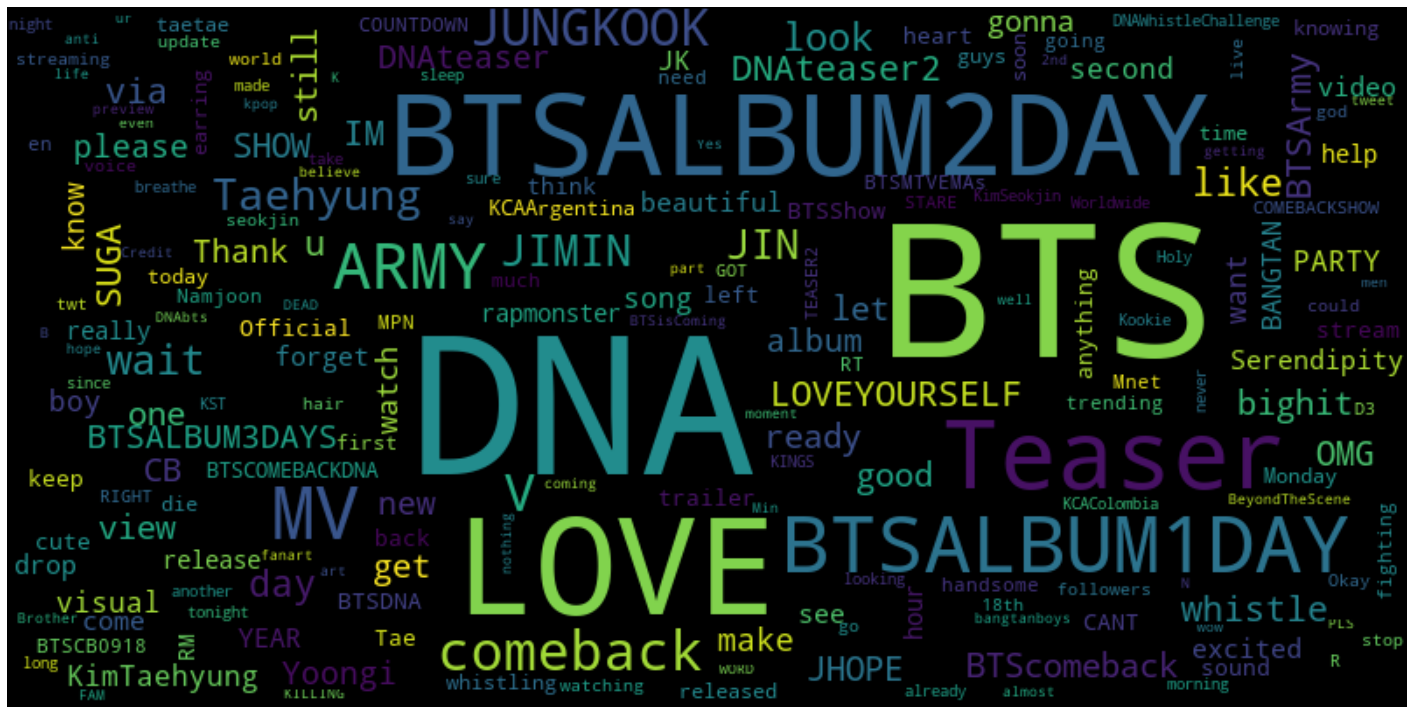

In [16]:
#plotting wordcloud from tweets

words_wb = ' '.join( [tweets for tweets in df_weekbefore["text"]] )
wordcloud_wb = WordCloud(width = 800, height = 400, random_state = 10, 
                         max_font_size=110, collocations = False, 
                         stopwords = stop_words).generate(words_wb)

plt.figure( figsize = (20,10) )
plt.imshow(wordcloud_wb, interpolation='bilinear')
plt.tight_layout(pad = 0)
plt.axis("off")
plt.show()

### LDA - Topic Modelling

#### Preprocessing for LDA

In [48]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))

wb_words = list(sent_to_words(df_weekbefore["text"]))

stop_words = stopwords.words('english')

# Build bigram and trigram models

bigram = gensim.models.Phrases(wb_words, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[wb_words], threshold = 100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(text):
  return [bigram_mod[doc] for doc in text]

wb_clean_words = remove_stopwords(wb_words)
wb_bigram = make_bigrams(wb_clean_words)

#Create Dictionary and Corpus

id2word_wb = corpora.Dictionary(wb_bigram)
texts_wb = wb_bigram
corpus_wb = [id2word_wb.doc2bow(text) for text in texts_wb]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


#### LDA base model

In [67]:
#LDA model training 
random.seed(10)
LDA = gensim.models.ldamodel.LdaModel
lda_wb = LDA(corpus=corpus_wb,
             id2word = id2word_wb,
             num_topics = 10,
             per_word_topics = True,
             passes = 1,
             eval_every = None)

# lda_wb.print_topics()
# doc_lda = lda_wb[corpus_wb]

# Perplexity Score - Lower the Better
print('Perplexity Score: ', round(lda_wb.log_perplexity(corpus_wb), 3))

#Computing Coherence Score - Higher, More Human Interpretable
coherence_model_lda = CoherenceModel(model = lda_wb,
                              texts = wb_bigram,
                              dictionary = id2word_wb,
                              coherence='c_v')

coherence_wb = coherence_model_lda.get_coherence()
print('Coherence Socre: ', round(coherence_wb, 3))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Perplexity Score:  -5.886
Coherence Socre:  0.321


For this base model, 
<br> Perplexity Score is -5.886
<br> Coherence Score: 0.321

#### Finding Best Parameters

In [68]:
# Hyperparameter Tuning
# Grid Search
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(df_weekbefore['lemmas_to_text'])

In [69]:
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid = search_params)

model.fit(data_vectorized)
GridSearchCV(cv = None, error_score = 'raise',
             estimator = LatentDirichletAllocation(batch_size = 128,
                                                   doc_topic_prior = None,
                                                   evaluate_every = -1,
                                                   learning_decay = 0.7,
                                                   learning_method = None,
                                                   learning_offset = 10.0,
                                                   max_doc_update_iter = 100,
                                                   max_iter = 10,
                                                   mean_change_tol = 0.001,
                                                   n_components = 10,
                                                   n_jobs = 1,
                                                   perp_tol = 0.1,
                                                   random_state = None,
                                                   topic_word_prior = None,
                                                   total_samples = 1000000.0,
                                                   verbose = 0),
             n_jobs = 1,
             param_grid = {'n_topics' : [10, 15, 20, 30],
                           'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch = '2*n_jobs', refit = True, return_train_score = 'warn',
             scoring = None, verbose = 0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             n_jobs=1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_topics': [10, 15, 20, 30]},
             return_train_score='warn')

In [70]:
best_lda = model.best_estimator_

#Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -21512.113889121105
Model Perplexity:  380.0589263539869


#### Finding optimal number of topics to have the best coherence

In [71]:
#Defining function to loop over number of topics to be used to find an
#optimal number of topics

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
  coherence_values_topic = []
  model_list_topic = []
  for num_topics in range(start, limit, step):
    model = LdaMulticore(corpus=corpus, num_topics = num_topics, id2word = id2word_wb)
    model_list_topic.append(model)
    coherencemodel = CoherenceModel(model=model, texts = texts, dictionary=dictionary, coherence = 'c_v')
    coherence_values_topic.append(coherencemodel.get_coherence())
  
  return model_list_topic, coherence_values_topic

In [72]:
model_list_topic, coherence_values_topic = compute_coherence_values(dictionary = id2word_wb,
                                                                    corpus = corpus_wb,
                                                                    texts = wb_bigram,
                                                                    start = 2, limit = 200, step = 6)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [73]:
print(len(coherence_values_topic))
print(len(model_list_topic))

# From this, we can estimate that with 33 topics, the model can bring the most optimal result

33
33


#### Final LDA model

In [ ]:
# Final model

lda_model_wb = LdaMulticore(corpus = corpus_wb,
                            id2word = id2word_wb,
                            num_topics = 33,
                            decay = 0.9, 
                            passes = 10)

In [75]:
lda_model_wb.print_topics()

[(10,
  '0.105*"bts" + 0.103*"dna" + 0.057*"jungkook" + 0.056*"suga" + 0.054*"love" + 0.042*"jimin" + 0.037*"jin" + 0.037*"jhope" + 0.030*"btsalbum" + 0.029*"day"'),
 (2,
  '0.119*"bts" + 0.116*"dna" + 0.089*"btsalbum" + 0.083*"days" + 0.062*"love" + 0.040*"wait" + 0.019*"teaser" + 0.017*"omg" + 0.015*"see" + 0.015*"comeback"'),
 (17,
  '0.109*"dna" + 0.104*"bts" + 0.065*"btsalbum" + 0.053*"days" + 0.044*"love" + 0.018*"day" + 0.010*"dnateaser" + 0.009*"like" + 0.009*"focus" + 0.007*"see"'),
 (26,
  '0.105*"bts" + 0.098*"dna" + 0.039*"btsalbum" + 0.027*"day" + 0.021*"days" + 0.017*"love" + 0.015*"ok" + 0.013*"cute" + 0.012*"army" + 0.011*"new"'),
 (8,
  '0.105*"bts" + 0.099*"dna" + 0.064*"btsalbum" + 0.052*"days" + 0.034*"love" + 0.019*"army" + 0.017*"comebackshow" + 0.015*"mnet" + 0.014*"day" + 0.013*"btscomeback"'),
 (22,
  '0.096*"dna" + 0.087*"bts" + 0.030*"btsalbum" + 0.028*"ready" + 0.026*"days" + 0.025*"love" + 0.023*"im" + 0.013*"loveyourself" + 0.012*"teaser" + 0.011*"mv"'),
 

In [76]:
print(round(lda_model_wb.log_perplexity(corpus_wb), 3))

coherence_model_lda = CoherenceModel(model = lda_model_wb,
                              texts = wb_bigram,
                              dictionary = id2word_wb,
                              coherence='c_v')
print(round(coherence_model_lda.get_coherence(), 3))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

-6.144
0.364


The final model of lda gives following result:
<br> perplexity score: -6.144
<br> coherence score: 0.364

In [77]:
# Visualiation

vis = pyLDAvis.gensim_models.prepare(lda_model_wb, corpus_wb, id2word_wb)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
31    -0.183516 -0.129623       1        1  11.360156
27    -0.075020 -0.017599       2        1   6.162273
21    -0.070505  0.053857       3        1   4.893820
12    -0.082882 -0.057922       4        1   4.792615
7     -0.091597  0.062428       5        1   4.612381
20    -0.070418  0.032093       6        1   4.539774
11    -0.058009  0.044309       7        1   4.396579
5     -0.056881  0.067571       8        1   4.028453
2     -0.077895  0.014596       9        1   3.993023
30    -0.056156 -0.037594      10        1   3.518995
1     -0.047569  0.006076      11        1   3.511785
10    -0.054357  0.031218      12        1   3.303342
8     -0.036846  0.070628      13        1   3.303225
23    -0.020996 -0.015562      14        1   3.151896
4     -0.046934 -0.011683      15        1   3.105998
17    -0.031446  0.035559      16        1   3.021218
14    -0.029602 -0.018209      17        1   2.848935
22    -0.004979 -0.033865      18        1   2.596570
24    -0.042960 -0.015403      19        1   2.484041
26     0.001268 -0.009843      20        1   2.380130
13     0.005392  0.009230      21        1   2.151976
6     -0.011360  0.033736      22        1   2.072986
16     0.032682  0.001504      23        1   1.908010
25     0.023850  0.041416      24        1   1.891449
9      0.034031  0.019868      25        1   1.817815
19     0.024093 -0.153301      26        1   1.747474
15     0.048742  0.026015      27        1   1.732247
0      0.088687  0.024963      28        1   1.024745
32     0.145751 -0.080199      29        1   0.889783
3      0.171712 -0.060448      30        1   0.886703
18     0.125329  0.017535      31        1   0.872993
28     0.157166  0.034938      32        1   0.588338
29     0.291221  0.013710      33        1   0.410274, topic_info=         Term         Freq        Total Category  logprob  loglift
73     teaser   227.000000   227.000000  Default  30.0000  30.0000
0         bts   975.000000   975.000000  Default  29.0000  29.0000
43         mv   131.000000   131.000000  Default  28.0000  28.0000
5    btsalbum   443.000000   443.000000  Default  27.0000  27.0000
1         dna  1042.000000  1042.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
15        see     0.018549    12.199283  Topic33  -7.5805  -0.9926
16  legendary     0.018549     1.611364  Topic33  -7.5805   1.0317
17    letters     0.018549     1.611364  Topic33  -7.5805   1.0317
18        six     0.018549     1.611364  Topic33  -7.5805   1.0317
19      storm     0.018549     1.611364  Topic33  -7.5805   1.0317

[1787 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
956      11  0.612687    aaaaaaaaa
1405     11  0.612687       aahhhh
1597      6  0.612136   absolutely
939      14  0.614129      abusing
27       21  0.613443          acc
...     ...       ...          ...
259       3  0.479315      youtube
259       5  0.239658      youtube
968      14  0.614129  yyyaaaassss
1092     27  0.600180      zealand
1560      3  0.609413        zines

[2669 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[32, 28, 22, 13, 8, 21, 12, 6, 3, 31, 2, 11, 9, 24, 5, 18, 15, 23, 25, 27, 14, 7, 17, 26, 10, 20, 16, 1, 33, 4, 19, 29, 30])

## Week of the Release

### Collecting Tweets / Preprocess

In [24]:
# A week of the release
random.seed(10)

df_week = pd.DataFrame(itertools.islice(
    sntwitter.TwitterSearchScraper(
    'DNA AND BTS AND #bts AND #dna OR billboard OR #streaming since:2017-09-18 until:2017-09-24 lang:"en"').get_items(), 2300))

df_week['Id'] = range(1, len(df_week) + 1)
first_column = df_week.pop('Id')
df_week.insert(0, 'Id', first_column)

# Remove Timzones and convert date to pd format

df_week['date'] = df_week['date'].apply(remove_timezone)
df_week['date'] = pd.to_datetime(df_week['date'])

#Preprocessing Tweets

df_week['text'] = df_week.content.apply(lambda x: re.sub(r'https?:\/\/\S+', ' ', x))
df_week['text'] = df_week.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", ' ', x))
df_week['text'] = df_week.text.apply(lambda x: re.sub(r"\b's\b", ' ', x))
df_week['text'] = df_week.text.apply(lambda x: re.sub(r'{link}', ' ', x))
df_week['text'] = df_week.text.apply(lambda x: re.sub(r"\[video\]", ' ', x))
df_week['text'] = df_week.text.apply(lambda x: re.sub(r'&[a-z]+;', ' ', x))
df_week['text'] = df_week.text.apply(lambda x: re.sub(r'\s*@\w+', ' ', x))
df_week['text'] = df_week.text.apply(lambda x: re.sub(r'[^\w]', ' ', x))
df_week['text'] = df_week.text.apply(lambda x: re.sub(r'\n', ' ', x))
df_week['text'] = df_week.text.apply(lambda x: re.sub(r'[^a-zA-Z0-9]+', ' ', x))


df_week['tokens'] = df_week['content'].apply(tknzr.tokenize)

#List all hastags added to a new column as a new feature 'hashtag'
df_week['hashtag'] = df_week['content'].apply(lambda x: 
                                    re.findall(r"#(\w+)", x))

df_week['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df_week['tokens']]
df_week['tokens_back_to_text'] = df_week['tokens_back_to_text'].str.replace(r'\s*@\w+', '', regex=True)
df_week['tokens_back_to_text'] = df_week['tokens_back_to_text'].str.replace(r"\b's\b", ' ', regex = True)
df_week['tokens_back_to_text'] = df_week['tokens_back_to_text'].str.replace(r'[^\w]', ' ', regex = True)
df_week['tokens_back_to_text'] = df_week['tokens_back_to_text'].str.replace(r'[^a-zA-Z0-9]+', ' ', regex = True)

#Lemmatization
df_week['lemmas'] = df_week['tokens_back_to_text'].apply(get_lemmas)

df_week['lemmas_to_text'] = [' '.join(map(str, l)) for l in df_week['lemmas']]
df_week['lemma_tokens'] = df_week['lemmas_to_text'].apply(tknzr.tokenize)

#manually removing unrelated tweets
df_week = df_week[~df_week.text.str.contains('frizzy')]

df_week.head()

Id                                                url                date  \
1   2  https://twitter.com/BTS_BiTS/status/9117414012... 2017-09-23 23:57:44   
2   3  https://twitter.com/De_licia1/status/911741368... 2017-09-23 23:57:36   
3   4  https://twitter.com/BTS_CaliBabe/status/911740... 2017-09-23 23:54:54   
4   5  https://twitter.com/BTS_CaliBabe/status/911740... 2017-09-23 23:54:33   
5   6  https://twitter.com/BTS_CaliBabe/status/911740... 2017-09-23 23:54:10   

                                             content                  id  \
1  #BTS #DNA is at #41 on Spotify Global Top 50. ...  911741401238429696   
2  If this happens, OMG, I'm going to be a mess l...  911741368929722368   
3  @OnAirRomeo pretty pls w/ cherry on top, play ...  911740691146928128   
4  @OnAirRomeo I would like to please hear #DNA b...  911740603536252928   
5  I would like you to pls play @OnAirRomeo #DNA ...  911740506282979328   

       username                                           outlinks  \
1      BTS_BiTS  [https://open.spotify.com/track/5SE57ljOIUJ1yb...   
2     De_licia1  [https://twitter.com/popcrave/status/911719815...   
3  BTS_CaliBabe                                                 []   
4  BTS_CaliBabe                                                 []   
5  BTS_CaliBabe                                                 []   

                                          outlinksss  \
1  https://open.spotify.com/track/5SE57ljOIUJ1ybL...   
2  https://twitter.com/popcrave/status/9117198158...   
3                                                      
4                                                      
5                                                      

                 tcooutlinks            tcooutlinksss  \
1  [https://t.co/SDAZWrxgeG]  https://t.co/SDAZWrxgeG   
2  [https://t.co/n33JASfnyX]  https://t.co/n33JASfnyX   
3                         []                            
4                         []                            
5                         []                            

                                                text  \
1   BTS DNA is at 41 on Spotify Global Top 50 Let...   
2  If this happens OMG I m going to be a mess lik...   
3   pretty pls w cherry on top play DNA by BTS Mo...   
4   I would like to please hear DNA by BTS MostRe...   
5  I would like you to pls play DNA by BTS MostRe...   

                                              tokens  \
1  [#BTS, #DNA, is, at, #41, on, Spotify, Global,...   
2  [If, this, happens, ,, OMG, ,, I'm, going, to,...   
3  [@OnAirRomeo, pretty, pls, w, /, cherry, on, t...   
4  [@OnAirRomeo, I, would, like, to, please, hear...   
5  [I, would, like, you, to, pls, play, @OnAirRom...   

                                             hashtag  \
1                                     [BTS, DNA, 41]   
2                                   [ARMY, BTS, DNA]   
3  [DNA, BTS, MostRequestedLive, BTSonUSARadio, B...   
4  [DNA, BTS, MostRequestedLive, BTSonUSARadio, B...   
5  [DNA, BTS, MostRequestedLive, BTSonUSARadio, B...   

                                 tokens_back_to_text  \
1   BTS DNA is at 41 on Spotify Global Top 50 Let...   
2  If this happens OMG I m going to be a mess lik...   
3   pretty pls w cherry on top play DNA by BTS Mo...   
4   I would like to please hear DNA by BTS MostRe...   
5  I would like you to pls play DNA by BTS MostRe...   

                                              lemmas  \
1  [ , BTS, dna, 41, spotify, Global, 50, let, 40...   
2  [happen, OMG, m, go, mess, like, year, MAMA, A...   
3  [ , pretty, pls, w, cherry, play, dna, BTS, mo...   
4  [ , like, hear, dna, BTS, mostrequestedlive, B...   
5  [like, pls, play, dna, BTS, mostrequestedlive,...   

                                      lemmas_to_text  \
1    BTS dna 41 spotify Global 50 let 40 Stream h...   
2  happen OMG m go mess like year MAMA ARMY let s...   
3    pretty pls w cherry play dna BTS mostrequest...   
4    like hear dna BTS mostrequestedlive BTSonUSA...   

In [35]:
num_unique_users_w = len(df_week.username.unique())

In [138]:
df_week['username'].str.contains('bts_bighit').value_counts()

False    1155
Name: username, dtype: int64

### VADER Analysis

In [25]:
# Vader analysis

# Get Polarity Scores
sia = SentimentIntensityAnalyzer()
res_w = {}
for i, row in tqdm(df_week.iterrows(), total=len(df_week)):
  text = row['text']
  myid = row['Id']
  res_w[myid] = sia.polarity_scores(text)
pd.DataFrame(res_w).T

  0%|          | 0/1155 [00:00<?, ?it/s]

neg    neu    pos  compound
2     0.000  0.806  0.194    0.3818
3     0.114  0.773  0.114    0.0000
4     0.000  0.479  0.521    0.7717
5     0.000  0.652  0.348    0.5859
6     0.000  0.592  0.408    0.6369
...     ...    ...    ...       ...
2296  0.241  0.759  0.000   -0.2263
2297  0.000  1.000  0.000    0.0000
2298  0.000  1.000  0.000    0.0000
2299  0.095  0.681  0.224    0.5904
2300  0.000  0.854  0.146    0.3818

[1155 rows x 4 columns]

In [34]:
pd.DataFrame(res_w).T.describe()

neg          neu          pos     compound
count  1155.000000  1155.000000  1155.000000  1155.000000
mean      0.031803     0.773229     0.194965     0.328461
std       0.078829     0.187562     0.181844     0.397427
min       0.000000     0.280000     0.000000    -0.885100
25%       0.000000     0.628000     0.000000     0.000000
50%       0.000000     0.765000     0.184000     0.340000
75%       0.000000     1.000000     0.340500     0.712500
max       0.548000     1.000000     0.720000     0.975800

In [26]:
#Merge the polarity scores data frame with main data frame
df_week_vader = pd.DataFrame(res_w).T
df_week_vader = df_week_vader.reset_index().rename(columns = {'index': 'Id'})
df_week_vader = df_week_vader.merge(df_weekbefore, how= 'left')

#Compute Negative Neutral and Positive
def GetAnalysis(score):
  if score <0:
    return "Negative"
  elif score==0:
    return "Neutral"
  else:
    return "Positive"

df_week_vader['VaderAnalysis']=df_week_vader['compound'].apply(GetAnalysis)
# df_week_vader['VaderAnalysis'].head()

#Percentage of positive tweets 
positiveTweets_w = df_week_vader[df_week_vader.VaderAnalysis == 'Positive']
positiveTweets_w_pct = round((positiveTweets_w.shape[0]/df_week_vader.shape[0])*100, 1)
print(f'Percentage of Positive Tweets is {positiveTweets_w_pct}')

#Percentage of negative tweets
negativeTweets_w = df_week_vader[df_week_vader.VaderAnalysis == 'Negative']
negativeTweets_w_pct = round((negativeTweets_w.shape[0]/df_week_vader.shape[0])*100, 1)
print(f'Percentage of Negative Tweets is {negativeTweets_w_pct}')

#Percentage of neutral tweets
neutralTweets_w = df_week_vader[df_week_vader.VaderAnalysis == 'Neutral']
neutralTweets_w_pct = round((neutralTweets_w.shape[0]/df_week_vader.shape[0])*100, 1)
print(f'Percentage of Neutral Tweets is {neutralTweets_w_pct}')

Percentage of Positive Tweets is 60.0
Percentage of Negative Tweets is 8.9
Percentage of Neutral Tweets is 31.1


#### Wordcloud

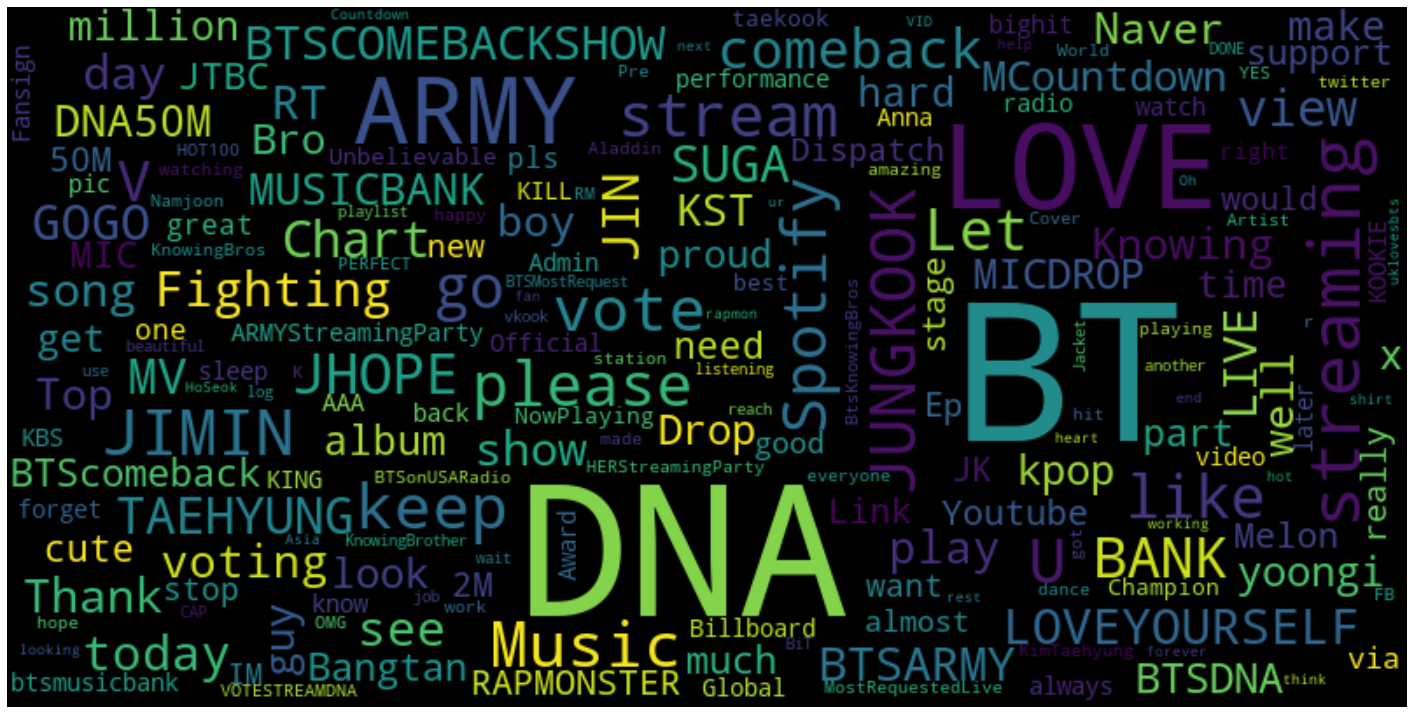

In [126]:
#plotting wordcloud from tweets

words_w = ' '.join( [tweets for tweets in df_week["text"]] )
wordcloud_w = WordCloud(width = 800, height = 400, random_state = 10, 
                        max_font_size=110, collocations = False, 
                        stopwords = stop_words).generate(words_w)

plt.figure( figsize = (20,10) )
plt.imshow(wordcloud_w, interpolation='bilinear')
plt.tight_layout(pad = 0)
plt.axis("off")
plt.show()

### LDA - Topic Modelling

#### Preprocessing for LDA

In [49]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))

w_words = list(sent_to_words(df_week["text"]))

stop_words = stopwords.words('english')

# Build bigram and trigram models

bigram = gensim.models.Phrases(w_words, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[w_words], threshold = 100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(text):
  return [bigram_mod[doc] for doc in text]

def make_trigram(text):
  return [trigram_mod[bigram_mod[doc]] for doc in text]

w_clean_words = remove_stopwords(w_words)
w_bigram = make_bigrams(w_clean_words)

#Create Dictionary and Corpus

id2word_w = corpora.Dictionary(w_bigram)
texts_w = w_bigram
corpus_w = [id2word_w.doc2bow(text) for text in texts_w]

#### LDA base model

In [78]:
#LDA model training 

LDA = gensim.models.ldamodel.LdaModel
lda_w = LDA(corpus=corpus_w,
             id2word = id2word_w,
             num_topics = 10,
             per_word_topics = True,
             passes = 20,
             eval_every = None)

# lda_w.print_topics()
# doc_lda = lda_w[corpus_w]

# Perplexity Score - Lower the Better
print('Perplexity Score: ', round(lda_w.log_perplexity(corpus_w), 3))

#Computing Coherence Score - Higher, More Human Interpretable
coherence_model_lda = CoherenceModel(model = lda_w,
                              texts = w_bigram,
                              dictionary = id2word_w,
                              coherence='c_v')

coherence_w = coherence_model_lda.get_coherence()
print('Coherence Socre: ', round(coherence_w, 3))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Perplexity Score:  -6.086
Coherence Socre:  0.375


For this base model, 
<br> Perplexity Score is -6.086
<br> Coherence Score: 0.375

#### Finding Best Parameters

In [79]:
# Hyperparameter Tuning
# Grid Search
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(df_week['lemmas_to_text'])

search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid = search_params)

model.fit(data_vectorized)
GridSearchCV(cv = None, error_score = 'raise',
             estimator = LatentDirichletAllocation(batch_size = 128,
                                                   doc_topic_prior = None,
                                                   evaluate_every = -1,
                                                   learning_decay = 0.7,
                                                   learning_method = None,
                                                   learning_offset = 10.0,
                                                   max_doc_update_iter = 100,
                                                   max_iter = 10,
                                                   mean_change_tol = 0.001,
                                                   n_components = 10,
                                                   n_jobs = 1,
                                                   perp_tol = 0.1,
                                                   random_state = None,
                                                   topic_word_prior = None,
                                                   total_samples = 1000000.0,
                                                   verbose = 0),
             n_jobs = 1,
             param_grid = {'n_topics' : [10, 15, 20, 30],
                           'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch = '2*n_jobs', refit = True, return_train_score = 'warn',
             scoring = None, verbose = 0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             n_jobs=1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_topics': [10, 15, 20, 30]},
             return_train_score='warn')

In [80]:
best_lda = model.best_estimator_

#Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -26134.432244611162
Model Perplexity:  459.46886739774664


Finding optimal number of topics to have the best coherence

In [81]:
#Defining function to loop over number of topics to be used to find an
#optimal number of topics

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
  coherence_values_topic = []
  model_list_topic = []
  for num_topics in range(start, limit, step):
    model = LdaMulticore(corpus=corpus, num_topics = num_topics, id2word = id2word_w)
    model_list_topic.append(model)
    coherencemodel = CoherenceModel(model=model, texts = texts, dictionary=dictionary, coherence = 'c_v')
    coherence_values_topic.append(coherencemodel.get_coherence())
  
  return model_list_topic, coherence_values_topic

model_list_topic, coherence_values_topic = compute_coherence_values(dictionary = id2word_w,
                                                                    corpus = corpus_w,
                                                                    texts = w_bigram,
                                                                    start = 2, limit = 200, step = 6)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [82]:
print(len(coherence_values_topic))
print(len(model_list_topic))

# From this, we can estimate that with 33 topics, the model can bring the most optimal result

33
33


#### Final LDA model

In [84]:
# Final model

lda_model_w = LdaMulticore(corpus = corpus_w,
                            id2word = id2word_w,
                            num_topics = 33,
                            decay = 0.9)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [85]:
lda_model_w.print_topics()

[(28,
  '0.132*"bts" + 0.123*"dna" + 0.013*"army" + 0.013*"love" + 0.012*"vote" + 0.012*"streaming" + 0.010*"please" + 0.009*"need" + 0.008*"today" + 0.007*"guys"'),
 (10,
  '0.131*"bts" + 0.121*"dna" + 0.042*"love" + 0.016*"top" + 0.015*"jhope" + 0.014*"jimin" + 0.014*"army" + 0.012*"go" + 0.012*"spotify" + 0.011*"jungkook"'),
 (20,
  '0.115*"bts" + 0.102*"dna" + 0.032*"love" + 0.029*"army" + 0.026*"vote" + 0.023*"streaming" + 0.019*"please" + 0.016*"spotify" + 0.013*"keep" + 0.013*"stream"'),
 (6,
  '0.129*"dna" + 0.106*"bts" + 0.025*"love" + 0.021*"streaming" + 0.021*"jungkook" + 0.015*"army" + 0.013*"keep" + 0.011*"armys" + 0.010*"comeback" + 0.009*"please"'),
 (22,
  '0.130*"dna" + 0.127*"bts" + 0.020*"stream" + 0.014*"music" + 0.014*"bank" + 0.012*"love" + 0.012*"vote" + 0.011*"mv" + 0.009*"voting" + 0.009*"streaming"'),
 (16,
  '0.133*"bts" + 0.109*"dna" + 0.089*"love" + 0.016*"jungkook" + 0.013*"army" + 0.011*"btsdna" + 0.009*"streaming" + 0.009*"bighit" + 0.009*"music" + 0.009

In [86]:
print(round(lda_model_w.log_perplexity(corpus_w), 3))
coherence_model_lda = CoherenceModel(model = lda_model_w,
                              texts = w_bigram,
                              dictionary = id2word_w,
                              coherence='c_v')
print(round(coherence_model_lda.get_coherence(), 3))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

-6.738
0.345


The final model of lda gives following result:
<br> perplexity score: -6.738
<br> coherence score: 0.345

In [87]:
# Visualiation

vis = pyLDAvis.gensim_models.prepare(lda_model_w, corpus_w, id2word_w)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
26    -0.114577  0.018614       1        1  9.254775
4     -0.082732 -0.031083       2        1  6.322998
28    -0.062248 -0.009892       3        1  5.369641
18    -0.082189  0.045069       4        1  5.255944
9     -0.071487 -0.015532       5        1  4.933619
7     -0.080000 -0.042986       6        1  4.891682
6     -0.069321 -0.027988       7        1  4.651013
10    -0.068992  0.062585       8        1  3.874192
16    -0.071912  0.006806       9        1  3.787513
14    -0.058266  0.002825      10        1  3.741297
25    -0.016938 -0.044182      11        1  3.697302
23    -0.050654 -0.006489      12        1  3.647702
2     -0.059062  0.051669      13        1  3.340191
20    -0.026235  0.038351      14        1  3.315773
13     0.007838 -0.134168      15        1  3.178590
22    -0.042547 -0.034545      16        1  3.080671
24    -0.044114  0.039536      17        1  2.964745
31    -0.033839 -0.046097      18        1  2.902190
27    -0.044372  0.073019      19        1  2.707225
12    -0.015085  0.064127      20        1  2.357545
30     0.009894  0.053967      21        1  2.318125
0     -0.010487  0.000642      22        1  2.023914
11    -0.006423 -0.083214      23        1  1.870000
32     0.038230 -0.085836      24        1  1.826920
1      0.040925  0.005807      25        1  1.713659
5      0.069005  0.038691      26        1  1.309271
19     0.080455  0.011652      27        1  1.194016
8      0.105869 -0.009906      28        1  1.046973
3      0.141240 -0.046719      29        1  0.786844
17     0.168156  0.011742      30        1  0.747154
15     0.119517  0.068144      31        1  0.735813
21     0.180444  0.006022      32        1  0.601256
29     0.149907  0.019366      33        1  0.551449, topic_info=            Term         Freq        Total Category  logprob  loglift
44          love   307.000000   307.000000  Default  30.0000  30.0000
1            dna  1143.000000  1143.000000  Default  29.0000  29.0000
0            bts  1225.000000  1225.000000  Default  28.0000  28.0000
123         vote    74.000000    74.000000  Default  27.0000  27.0000
6         stream    64.000000    64.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
326         link     0.085914    14.578285  Topic33  -6.4783   0.0664
637  performance     0.068346    11.640486  Topic33  -6.7070   0.0627
657         live     0.080483    17.001013  Topic33  -6.5436  -0.1526
963         bank     0.097319    51.802408  Topic33  -6.3536  -1.0768
122        today     0.075105    35.361420  Topic33  -6.6127  -0.9541

[2006 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
452       2  0.125869   aaa
452       3  0.125869   aaa
452       6  0.314672   aaa
452       8  0.062934   aaa
452      10  0.125869   aaa
...     ...       ...   ...
290      11  0.141696    yt
290      20  0.141696    yt
290      24  0.141696    yt
1047      9  0.790491   yum
85        2  0.603067  zkel

[3624 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[27, 5, 29, 19, 10, 8, 7, 11, 17, 15, 26, 24, 3, 21, 14, 23, 25, 32, 28, 13, 31, 1, 12, 33, 2, 6, 20, 9, 4, 18, 16, 22, 30])

## Week after the Release

### Collecting Tweets / Preprocess

In [27]:
# A Week after the release
random.seed(10)

df_week1 = pd.DataFrame(itertools.islice(
    sntwitter.TwitterSearchScraper(
    'DNA AND BTS AND #bts AND #dna OR billboard OR #streaming since:2017-09-25 until:2017-10-01 lang:"en"').get_items(), 1001))

df_week1['Id'] = range(1, len(df_week1) + 1)
first_column = df_week1.pop('Id')
df_week1.insert(0, 'Id', first_column)

# Remove Timzones and convert date to pd format

df_week1['date'] = df_week1['date'].apply(remove_timezone)
df_week1['date'] = pd.to_datetime(df_week1['date'])

#Preprocessing Tweets

df_week1['text'] = df_week1.content.apply(lambda x: re.sub(r'https?:\/\/\S+', ' ', x))
df_week1['text'] = df_week1.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", ' ', x))
df_week1['text'] = df_week1.text.apply(lambda x: re.sub(r"\b's\b", ' ', x))
df_week1['text'] = df_week1.text.apply(lambda x: re.sub(r'{link}', ' ', x))
df_week1['text'] = df_week1.text.apply(lambda x: re.sub(r"\[video\]", ' ', x))
df_week1['text'] = df_week1.text.apply(lambda x: re.sub(r'&[a-z]+;', ' ', x))
df_week1['text'] = df_week1.text.apply(lambda x: re.sub(r'\s*@\w+', ' ', x))
df_week1['text'] = df_week1.text.apply(lambda x: re.sub(r'[^\w]', ' ', x))
df_week1['text'] = df_week1.text.apply(lambda x: re.sub(r'\n', ' ', x))
df_week1['text'] = df_week1.text.apply(lambda x: re.sub(r'[^a-zA-Z0-9]+', ' ', x))


df_week1['tokens'] = df_week1['content'].apply(tknzr.tokenize)

#List all hastags added to a new column as a new feature 'hashtag'
df_week1['hashtag'] = df_week1['content'].apply(lambda x: 
                                    re.findall(r"#(\w+)", x))

df_week1['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df_week1['tokens']]
df_week1['tokens_back_to_text'] = df_week1['tokens_back_to_text'].str.replace(r'\s*@\w+', '', regex=True)
df_week1['tokens_back_to_text'] = df_week1['tokens_back_to_text'].str.replace(r"\b's\b", ' ', regex = True)
df_week1['tokens_back_to_text'] = df_week1['tokens_back_to_text'].str.replace(r'[^\w]', ' ', regex = True)
df_week1['tokens_back_to_text'] = df_week1['tokens_back_to_text'].str.replace(r'[^a-zA-Z0-9]+', ' ', regex = True)

#Lemmatization
df_week1['lemmas'] = df_week1['tokens_back_to_text'].apply(get_lemmas)

df_week1['lemmas_to_text'] = [' '.join(map(str, l)) for l in df_week1['lemmas']]
df_week1['lemma_tokens'] = df_week1['lemmas_to_text'].apply(tknzr.tokenize)

df_week1 = df_week1[~df_week1.text.str.contains('mazda')]

df_week1.head()

Id                                                url                date  \
0   1  https://twitter.com/YQuiram/status/91427833889... 2017-09-30 23:58:37   
1   2  https://twitter.com/xxlee4/status/914276960783... 2017-09-30 23:53:08   
3   4  https://twitter.com/juddeart/status/9142720493... 2017-09-30 23:33:37   
4   5  https://twitter.com/juddeart/status/9142712652... 2017-09-30 23:30:30   
5   6  https://twitter.com/juddeart/status/9142708261... 2017-09-30 23:28:45   

                                             content                  id  \
0  @MostRequestLive @OnAirRomeo Please play #DNA ...  914278338893672448   
1  Don't forget to vote ARMYs https://t.co/ui6RAx...  914276960783798272   
3  @MostRequestLive @OnAirRomeo @LittleMix @Sabri...  914272049337597952   
4  @OnAirRomeo we would like to hear #DNA by @BTS...  914271265220947969   
5  hey @MostRequestLive @OnAirRomeo can you play ...  914270826198966272   

   username                                      outlinks  \
0   YQuiram                                            []   
1    xxlee4  [http://www.asiaartistawards.com/vote/lists]   
3  juddeart                                            []   
4  juddeart                                            []   
5  juddeart                                            []   

                                   outlinksss                tcooutlinks  \
0                                                                     []   
1  http://www.asiaartistawards.com/vote/lists  [https://t.co/ui6RAxT2VV]   
3                                                                     []   
4                                                                     []   
5                                                                     []   

             tcooutlinksss                                               text  \
0                                       Please play DNA BTS MostRequestedLive   
1  https://t.co/ui6RAxT2VV                 Don t forget to vote ARMYs DNA BTS   
3                            we would really like to hear DNA by BTS MostR...   
4                            we would like to hear DNA by BTS on Can you p...   
5                           hey can you play DNA by BTS please thank you M...   

                                              tokens  \
0  [@MostRequestLive, @OnAirRomeo, Please, play, ...   
1  [Don't, forget, to, vote, ARMYs, https://t.co/...   
3  [@MostRequestLive, @OnAirRomeo, @LittleMix, @S...   
4  [@OnAirRomeo, we, would, like, to, hear, #DNA,...   
5  [hey, @MostRequestLive, @OnAirRomeo, can, you,...   

                         hashtag  \
0  [DNA, BTS, MostRequestedLive]   
1                     [DNA, BTS]   
3  [DNA, BTS, MostRequestedLive]   
4  [DNA, BTS, MostRequestedLive]   
5  [DNA, BTS, MostRequestedLive]   

                                 tokens_back_to_text  \
0              Please play DNA BTS MostRequestedLive   
1  Don t forget to vote ARMYs https t co ui6RAxT2...   
3   we would really like to hear DNA by BTS MostR...   
4   we would like to hear DNA by BTS on Can you p...   
5  hey can you play DNA by BTS please thank you M...   

                                              lemmas  \
0             [ , play, dna, BTS, mostrequestedlive]   
1  [Don, t, forget, vote, ARMYs, https, t, co, ui...   
3       [ , like, hear, dna, BTS, mostrequestedlive]   
4  [ , like, hear, dna, BTS, play, thank, mostreq...   
5    [hey, play, dna, BTS, thank, mostrequestedlive]   

                                      lemmas_to_text  \
0                     play dna BTS mostrequestedlive   
1  Don t forget vote ARMYs https t co ui6raxt2vv ...   
3                like hear dna BTS mostrequestedlive   
4     like hear dna BTS play thank mostrequestedlive   
5           hey play dna BTS thank mostrequestedlive   

                                        lemma_tokens  
0                [play, dna, BTS, mostrequestedlive]  
1  [Don, t, forget, vote, ARMYs, https, t, co, ui...  
3          [like, hear, 

In [36]:
num_unique_users_w1 = len(df_week1.username.unique())

In [140]:
df_week1['username'].str.contains('bts_bighit').value_counts()

False    1000
Name: username, dtype: int64

### VADER Analysis

In [28]:
# Vader analysis

# Get Polarity Scores
sia = SentimentIntensityAnalyzer()
res_w1 = {}
for i, row in tqdm(df_week1.iterrows(), total=len(df_week1)):
  text = row['text']
  myid = row['Id']
  res_w1[myid] = sia.polarity_scores(text)
pd.DataFrame(res_w1).T

  0%|          | 0/1000 [00:00<?, ?it/s]

neg    neu    pos  compound
1     0.000  0.390  0.610    0.5719
2     0.241  0.759  0.000   -0.2263
4     0.000  0.763  0.237    0.4201
5     0.000  0.606  0.394    0.7783
6     0.000  0.526  0.474    0.7351
...     ...    ...    ...       ...
997   0.198  0.462  0.339    0.3470
998   0.000  0.469  0.531    0.5267
999   0.000  1.000  0.000    0.0000
1000  0.000  1.000  0.000    0.0000
1001  0.000  0.669  0.331    0.8360

[1000 rows x 4 columns]

In [38]:
pd.DataFrame(res_w1).T.describe()

neg          neu          pos     compound
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      0.027462     0.768925     0.203608     0.341181
std       0.072346     0.198162     0.197342     0.386881
min       0.000000     0.150000     0.000000    -0.844200
25%       0.000000     0.612000     0.000000     0.000000
50%       0.000000     0.765500     0.201000     0.383100
75%       0.000000     1.000000     0.354000     0.712500
max       0.538000     1.000000     0.850000     0.969900

In [29]:
#Merge the polarity scores data frame with main data frame
df_week1_vader = pd.DataFrame(res_w1).T
df_week1_vader = df_week1_vader.reset_index().rename(columns = {'index': 'Id'})
df_week1_vader = df_week1_vader.merge(df_week1, how= 'left')

#Compute Negative Neutral and Positive
def GetAnalysis(score):
  if score <0:
    return "Negative"
  elif score==0:
    return "Neutral"
  else:
    return "Positive"

df_week1_vader['VaderAnalysis']=df_week1_vader['compound'].apply(GetAnalysis)
# df_week1_vader['VaderAnalysis'].head()

#Percentage of positive tweets 
positiveTweets_w1 = df_week1_vader[df_week1_vader.VaderAnalysis == 'Positive']
positiveTweets_w1_pct = round((positiveTweets_w1.shape[0]/df_week1_vader.shape[0])*100, 1)
print(f'Percentage of Positive Tweets is {positiveTweets_w1_pct}')

#Percentage of negative tweets
negativeTweets_w1 = df_week1_vader[df_week1_vader.VaderAnalysis == 'Negative']
negativeTweets_w1_pct = round((negativeTweets_w1.shape[0]/df_week1_vader.shape[0])*100, 1)
print(f'Percentage of Negative Tweets is {negativeTweets_w1_pct}')

#Percentage of neutral tweets
neutralTweets_w1 = df_week1_vader[df_week1_vader.VaderAnalysis == 'Neutral']
neutralTweets_w1_pct = round((neutralTweets_w1.shape[0]/df_week1_vader.shape[0])*100, 1)
print(f'Percentage of Neutral Tweets is {neutralTweets_w1_pct}')

Percentage of Positive Tweets is 59.4
Percentage of Negative Tweets is 8.8
Percentage of Neutral Tweets is 31.8


#### Word Cloud

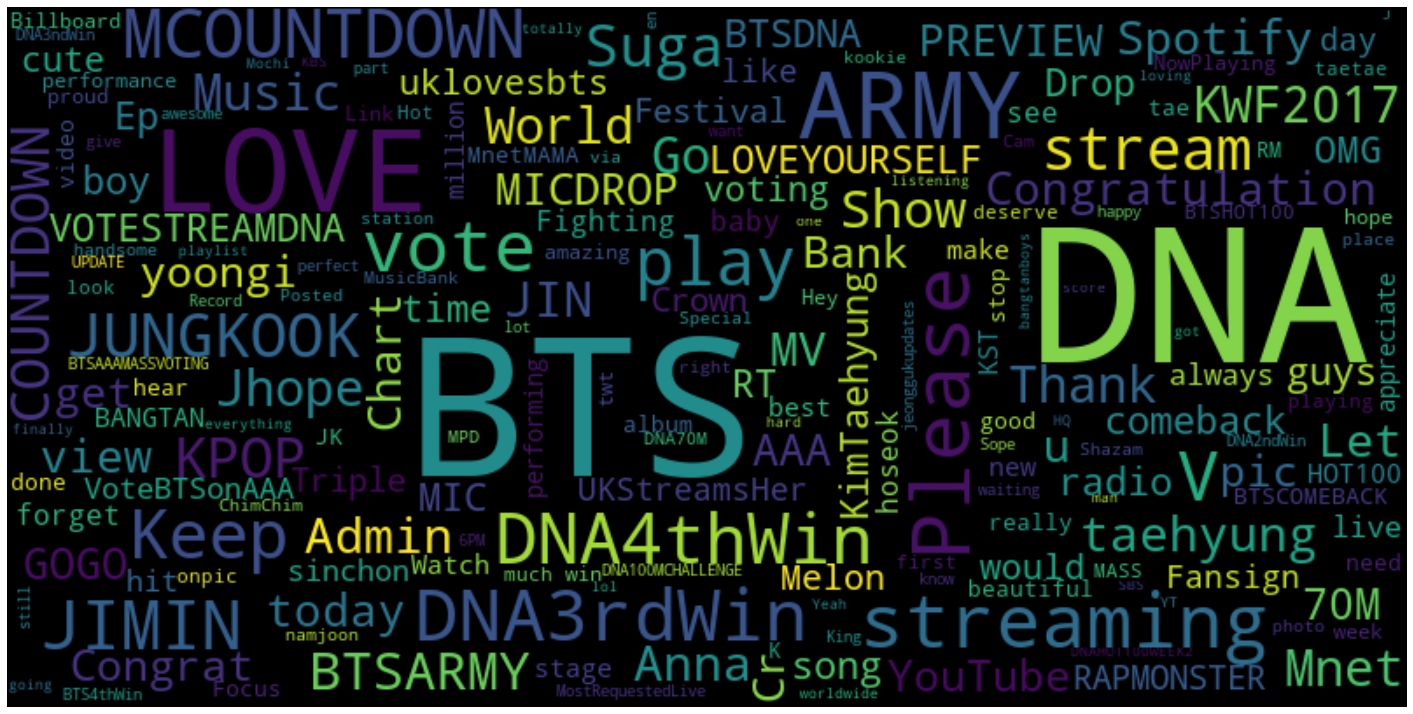

In [127]:
#plotting wordcloud from tweets

words_w1 = ' '.join( [tweets for tweets in df_week1["text"]] )
wordcloud_w1 = WordCloud(width = 800, height = 400, random_state = 10, 
                         max_font_size=110, collocations = False, 
                         stopwords = stop_words).generate(words_w1)
plt.figure( figsize = (20,10) )
plt.imshow(wordcloud_w1, interpolation='bilinear')
plt.tight_layout(pad = 0)
plt.axis("off")
plt.show()

### LDA - Topic Modelling

#### Preprocessing for LDA

In [50]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))

w1_words = list(sent_to_words(df_week1["text"]))

stop_words = stopwords.words('english')

# Build bigram and trigram models

bigram = gensim.models.Phrases(w1_words, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[w1_words], threshold = 100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(text):
  return [bigram_mod[doc] for doc in text]

def make_trigram(text):
  return [trigram_mod[bigram_mod[doc]] for doc in text]

w1_clean_words = remove_stopwords(w1_words)
w1_bigram = make_bigrams(w1_clean_words)

#Create Dictionary and Corpus

id2word_w1 = corpora.Dictionary(w1_bigram)
texts_w1 = w1_bigram
corpus_w1 = [id2word_w1.doc2bow(text) for text in texts_w1]

#### LDA base model

In [88]:
#LDA model training 

LDA = gensim.models.ldamodel.LdaModel
lda_w1 = LDA(corpus=corpus_w1,
             id2word = id2word_w1,
             num_topics = 10,
             per_word_topics = True,
             passes = 1,
             eval_every = None)


# Perplexity Score - Lower the Better
print('Perplexity Score: ', round(lda_w1.log_perplexity(corpus_w1), 3))

#Computing Coherence Score - Higher, More Human Interpretable
coherence_model_lda = CoherenceModel(model = lda_w1,
                              texts = w1_bigram,
                              dictionary = id2word_w1,
                              coherence='c_v')

coherence_w1 = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_w1, 3))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Perplexity Score:  -6.163
Coherence Score:  0.344


For this base model, 
<br> Perplexity Score is -6.163
<br> Coherence Score: 0.344

#### Finding Best Parameters

In [89]:
# Hyperparameter Tuning
# Grid Search
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(df_week1['lemmas_to_text'])

search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid = search_params)

model.fit(data_vectorized)
GridSearchCV(cv = None, error_score = 'raise',
             estimator = LatentDirichletAllocation(batch_size = 128,
                                                   doc_topic_prior = None,
                                                   evaluate_every = -1,
                                                   learning_decay = 0.7,
                                                   learning_method = None,
                                                   learning_offset = 10.0,
                                                   max_doc_update_iter = 100,
                                                   max_iter = 10,
                                                   mean_change_tol = 0.001,
                                                   n_components = 10,
                                                   n_jobs = 1,
                                                   perp_tol = 0.1,
                                                   random_state = None,
                                                   topic_word_prior = None,
                                                   total_samples = 1000000.0,
                                                   verbose = 0),
             n_jobs = 1,
             param_grid = {'n_topics' : [10, 15, 20, 30],
                           'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch = '2*n_jobs', refit = True, return_train_score = 'warn',
             scoring = None, verbose = 0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             n_jobs=1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_topics': [10, 15, 20, 30]},
             return_train_score='warn')

In [90]:
best_lda = model.best_estimator_

#Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -23442.949951034305
Model Perplexity:  453.70814108240097


In [ ]:
#Defining function to loop over number of topics to be used to find an
#optimal number of topics

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
  coherence_values_topic = []
  model_list_topic = []
  for num_topics in range(start, limit, step):
    model = LdaMulticore(corpus=corpus, num_topics = num_topics, id2word = id2word_w1)
    model_list_topic.append(model)
    coherencemodel = CoherenceModel(model=model, texts = texts, dictionary=dictionary, coherence = 'c_v')
    coherence_values_topic.append(coherencemodel.get_coherence())
  
  return model_list_topic, coherence_values_topic

model_list_topic, coherence_values_topic = compute_coherence_values(dictionary = id2word_w1,
                                                                    corpus = corpus_w1,
                                                                    texts = w1_bigram,
                                                                    start = 2, limit = 200, step = 6)


In [92]:
print(len(coherence_values_topic))
print(len(model_list_topic))

# From this, we can estimate that with 33 topics, the model can bring the most optimal result

33
33


#### Final LDA model

In [ ]:
# Final model

lda_model_w1 = LdaMulticore(corpus = corpus_w1,
                            id2word = id2word_w1,
                            num_topics = 33,
                            decay = 0.9)

In [94]:
lda_model_w1.print_topics()

[(8,
  '0.169*"dna" + 0.108*"bts" + 0.018*"rdwin" + 0.017*"mcountdown" + 0.012*"suga" + 0.011*"thwin" + 0.010*"love" + 0.010*"yoongi" + 0.010*"army" + 0.009*"views"'),
 (24,
  '0.028*"dna" + 0.028*"stream" + 0.028*"bts" + 0.014*"spot" + 0.014*"good" + 0.014*"onto" + 0.014*"hold" + 0.014*"army" + 0.014*"youtube" + 0.014*"everyone"'),
 (1,
  '0.161*"dna" + 0.118*"bts" + 0.057*"love" + 0.027*"rdwin" + 0.015*"thwin" + 0.012*"jimin" + 0.009*"please" + 0.009*"omg" + 0.008*"armys" + 0.007*"jungkook"'),
 (13,
  '0.078*"bts" + 0.071*"dna" + 0.042*"love" + 0.021*"jin" + 0.014*"keep" + 0.014*"mcountdown" + 0.014*"pre" + 0.014*"hot" + 0.014*"kookie" + 0.014*"eat"'),
 (19,
  '0.111*"dna" + 0.099*"bts" + 0.027*"streaming" + 0.023*"keep" + 0.014*"love" + 0.013*"armys" + 0.012*"lol" + 0.012*"spotify" + 0.010*"go" + 0.009*"youtube"'),
 (30,
  '0.120*"dna" + 0.096*"bts" + 0.029*"rdwin" + 0.027*"kpop" + 0.023*"world_festival" + 0.023*"love" + 0.018*"army" + 0.012*"radio" + 0.012*"streaming" + 0.012*"kwf"

In [95]:
print(round(lda_model_w1.log_perplexity(corpus_w1), 3))
coherence_model_lda = CoherenceModel(model = lda_model_w1,
                              texts = texts_w1,
                              dictionary = id2word_w1,
                              coherence='c_v')

print(round(coherence_model_lda.get_coherence(), 3))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

-6.655
0.378


The final model of lda gives following result:
<br> perplexity score: -6.655
<br> coherence score: 0.378

In [96]:
# Visualiation

vis = pyLDAvis.gensim_models.prepare(lda_model_w1, corpus_w1, id2word_w1)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.108209  0.009075       1        1  6.946269
2      0.065853  0.132461       2        1  6.782588
1      0.097272 -0.013302       3        1  6.439924
8      0.077478  0.058322       4        1  5.979780
17     0.077118 -0.049554       5        1  4.800564
15     0.059988  0.031951       6        1  4.774790
14     0.071487 -0.109590       7        1  4.590305
21     0.058936  0.060756       8        1  4.380158
20     0.071433 -0.033697       9        1  3.992521
25     0.074001  0.014208      10        1  3.904488
9      0.057371 -0.026049      11        1  3.300929
22     0.067077  0.031137      12        1  3.208299
3      0.068551 -0.046059      13        1  2.958623
23     0.012452 -0.025792      14        1  2.903710
19     0.048214 -0.044772      15        1  2.804316
16    -0.054509 -0.034088      16        1  2.742362
26    -0.012630  0.016981      17        1  2.666800
31    -0.000011  0.035420      18        1  2.595666
0      0.005560  0.044482      19        1  2.588606
29     0.044459  0.045613      20        1  2.580390
18     0.035091  0.013073      21        1  2.562852
28    -0.040988 -0.008999      22        1  2.413132
10    -0.055829 -0.103355      23        1  2.107028
30    -0.021274  0.026149      24        1  1.813161
12    -0.036646 -0.059009      25        1  1.643784
32    -0.001690  0.000972      26        1  1.589106
11    -0.014748 -0.036658      27        1  1.522579
13    -0.065201 -0.044155      28        1  1.348512
5     -0.150305  0.082470      29        1  1.313220
27    -0.140029  0.002667      30        1  1.005603
7     -0.126930  0.038666      31        1  0.716986
24    -0.192699 -0.003586      32        1  0.539151
4     -0.187062 -0.005736      33        1  0.483798, topic_info=       Term         Freq        Total Category  logprob  loglift
0       bts   960.000000   960.000000  Default  30.0000  30.0000
40     love   209.000000   209.000000  Default  29.0000  29.0000
1       dna  1106.000000  1106.000000  Default  28.0000  28.0000
3    please    96.000000    96.000000  Default  27.0000  27.0000
100  stream    49.000000    49.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
123      go     0.060538    40.051471  Topic33  -6.5675  -1.1634
44     army     0.059149    91.604716  Topic33  -6.5907  -2.0139
6      vote     0.050851    72.611730  Topic33  -6.7419  -1.9327
2      play     0.019431    61.652798  Topic33  -7.7039  -2.7311
3    please     0.019431    96.267285  Topic33  -7.7039  -3.1767

[1952 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
83        1  0.121616   aaa
83        2  0.040539   aaa
83        5  0.081078   aaa
83        7  0.121616   aaa
83        8  0.081078   aaa
...     ...       ...   ...
244       8  0.150641    yt
244      14  0.150641    yt
244      22  0.150641    yt
244      26  0.150641    yt
1471     20  0.639816  zone

[3364 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 2, 9, 18, 16, 15, 22, 21, 26, 10, 23, 4, 24, 20, 17, 27, 32, 1, 30, 19, 29, 11, 31, 13, 33, 12, 14, 6, 28, 8, 25, 5])

## 2 Weeks after the Release

### Collecting Tweets / Preprocess

In [30]:
# 2 Weeks after the release
random.seed(10)

df_week2 = pd.DataFrame(itertools.islice(
    sntwitter.TwitterSearchScraper(
    'DNA AND BTS AND #bts AND #dna OR billboard OR #streaming since:2017-10-02 until:2017-10-08 lang:"en"').get_items(), 1000))

df_week2['Id'] = range(1, len(df_week2) + 1)
first_column = df_week2.pop('Id')
df_week2.insert(0, 'Id', first_column)

# Remove Timzones and convert date to pd format

df_week2['date'] = df_week2['date'].apply(remove_timezone)
df_week2['date'] = pd.to_datetime(df_week2['date'])

#Preprocessing Tweets

df_week2['text'] = df_week2.content.apply(lambda x: re.sub(r'https?:\/\/\S+', ' ', x))
df_week2['text'] = df_week2.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", ' ', x))
df_week2['text'] = df_week2.text.apply(lambda x: re.sub(r"\b's\b", ' ', x))
df_week2['text'] = df_week2.text.apply(lambda x: re.sub(r'{link}', ' ', x))
df_week2['text'] = df_week2.text.apply(lambda x: re.sub(r"\[video\]", ' ', x))
df_week2['text'] = df_week2.text.apply(lambda x: re.sub(r'&[a-z]+;', ' ', x))
df_week2['text'] = df_week2.text.apply(lambda x: re.sub(r'\s*@\w+', ' ', x))
df_week2['text'] = df_week2.text.apply(lambda x: re.sub(r'[^\w]', ' ', x))
df_week2['text'] = df_week2.text.apply(lambda x: re.sub(r'\n', ' ', x))
df_week2['text'] = df_week2.text.apply(lambda x: re.sub(r'[^a-zA-Z0-9]+', ' ', x))


df_week2['tokens'] = df_week2['content'].apply(tknzr.tokenize)

#List all hastags added to a new column as a new feature 'hashtag'
df_week2['hashtag'] = df_week2['content'].apply(lambda x: 
                                    re.findall(r"#(\w+)", x))

df_week2['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df_week2['tokens']]
df_week2['tokens_back_to_text'] = df_week2['tokens_back_to_text'].str.replace(r'\s*@\w+', '', regex=True)
df_week2['tokens_back_to_text'] = df_week2['tokens_back_to_text'].str.replace(r"\b's\b", ' ', regex = True)
df_week2['tokens_back_to_text'] = df_week2['tokens_back_to_text'].str.replace(r'[^\w]', ' ', regex = True)
df_week2['tokens_back_to_text'] = df_week2['tokens_back_to_text'].str.replace(r'[^a-zA-Z0-9]+', ' ', regex = True)

#Lemmatization
df_week2['lemmas'] = df_week2['tokens_back_to_text'].apply(get_lemmas)

df_week2['lemmas_to_text'] = [' '.join(map(str, l)) for l in df_week2['lemmas']]
df_week2['lemma_tokens'] = df_week2['lemmas_to_text'].apply(tknzr.tokenize)

df_week2.head()

Id                                                url                date  \
0   1  https://twitter.com/ViihJeon/status/9168153512... 2017-10-07 23:59:48   
1   2  https://twitter.com/dearvmon/status/9168152485... 2017-10-07 23:59:23   
2   3  https://twitter.com/boxsmile2296/status/916815... 2017-10-07 23:59:13   
3   4  https://twitter.com/jhopeprotectz/status/91681... 2017-10-07 23:59:04   
4   5  https://twitter.com/ViihJeon/status/9168151381... 2017-10-07 23:58:57   

                                             content                  id  \
0  @ArmyDiario @MostRequestLive @OnAirRomeo @BTS_...  916815351291301888   
1  One more request for #DNA by #BTS here. Thanks...  916815248597966848   
2  @MostRequestLive @OnAirRomeo  luv to hear #DNA...  916815208382832640   
3  please play #DNA by @BTS_twt #BTS on #MostRequ...  916815168528580609   
4  @lemonadie @MostRequestLive @OnAirRomeo @BTS_t...  916815138170294273   

        username outlinks outlinksss tcooutlinks tcooutlinksss  \
0       ViihJeon       []                     []                 
1       dearvmon       []                     []                 
2   boxsmile2296       []                     []                 
3  jhopeprotectz       []                     []                 
4       ViihJeon       []                     []                 

                                                text  \
0   My request is DNA by BTS MostRequestedLive Ro...   
1  One more request for DNA by BTS here Thanks Mo...   
2   luv to hear DNA by BTS MostRequestedLive Rome...   
3  please play DNA by BTS on MostRequestedLive Ro...   
4   My request is DNA by BTS MostRequestedLive Ro...   

                                              tokens  \
0  [@ArmyDiario, @MostRequestLive, @OnAirRomeo, @...   
1  [One, more, request, for, #DNA, by, #BTS, here...   
2  [@MostRequestLive, @OnAirRomeo, luv, to, hear,...   
3  [please, play, #DNA, by, @BTS_twt, #BTS, on, #...   
4  [@lemonadie, @MostRequestLive, @OnAirRomeo, @B...   

                                       hashtag  \
0  [DNA, BTS, MostRequestedLive, RomeoPlayDNA]   
1  [DNA, BTS, MostRequestedLive, RomeoPlayDNA]   
2  [DNA, BTS, MostRequestedLive, RomeoPlayDNA]   
3  [DNA, BTS, MostRequestedLive, RomeoPlayDNA]   
4  [DNA, BTS, MostRequestedLive, RomeoPlayDNA]   

                                 tokens_back_to_text  \
0   My request is DNA by BTS MostRequestedLive Ro...   
1  One more request for DNA by BTS here Thanks Mo...   
2   luv to hear DNA by BTS MostRequestedLive Rome...   
3  please play DNA by BTS on MostRequestedLive Ro...   
4   My request is DNA by BTS MostRequestedLive Ro...   

                                              lemmas  \
0  [ , request, dna, BTS, mostrequestedlive, rome...   
1  [request, dna, BTS, thank, MostRequestedLive, ...   
2  [ , luv, hear, dna, BTS, mostrequestedlive, ro...   
3  [play, dna, BTS, mostrequestedlive, romeoplaydna]   
4  [ , request, dna, BTS, mostrequestedlive, rome...   

                                      lemmas_to_text  \
0    request dna BTS mostrequestedlive romeoplayd...   
1  request dna BTS thank MostRequestedLive RomeoP...   
2    luv hear dna BTS mostrequestedlive romeoplay...   
3        play dna BTS mostrequestedlive romeoplaydna   
4     request dna BTS mostrequestedlive romeoplaydna   

                                        lemma_tokens  
0  [request, dna, BTS, mostrequestedlive, romeopl...  
1  [request, dna, BTS, thank, MostRequestedLive, ...  
2  [luv, hear, dna, BTS, mostrequestedlive, romeo...  
3  [play, dna, BTS, mostrequestedlive, romeoplaydna]  
4  [request, dna, BTS, mostrequestedlive, romeopl...

In [37]:
num_unique_users_w2 = len(df_week2.username.unique())

In [141]:
df_week2['username'].str.contains('bts_bighit').value_counts()

False    1000
Name: username, dtype: int64

### VADER Analysis

In [31]:
# Vader analysis

# Get Polarity Scores
sia = SentimentIntensityAnalyzer()
res_w2 = {}
for i, row in tqdm(df_week2.iterrows(), total=len(df_week2)):
  text = row['text']
  myid = row['Id']
  res_w2[myid] = sia.polarity_scores(text)
pd.DataFrame(res_w2).T

  0%|          | 0/1000 [00:00<?, ?it/s]

neg    neu    pos  compound
1     0.0  1.000  0.000    0.0000
2     0.0  0.775  0.225    0.4404
3     0.0  1.000  0.000    0.0000
4     0.0  0.561  0.439    0.5719
5     0.0  1.000  0.000    0.0000
...   ...    ...    ...       ...
996   0.0  0.608  0.392    0.7964
997   0.0  1.000  0.000    0.0000
998   0.0  0.503  0.497    0.7125
999   0.0  0.735  0.265    0.6523
1000  0.0  0.577  0.423    0.6590

[1000 rows x 4 columns]

In [42]:
pd.DataFrame(res_w2).T.describe()

neg          neu          pos     compound
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      0.011337     0.718959     0.269709     0.392306
std       0.050465     0.204666     0.205919     0.324985
min       0.000000     0.242000     0.000000    -0.743000
25%       0.000000     0.560000     0.000000     0.000000
50%       0.000000     0.650500     0.332000     0.571900
75%       0.000000     1.000000     0.439000     0.571900
max       0.683000     1.000000     0.758000     0.990200

In [32]:
#Merge the polarity scores data frame with main data frame
df_week2_vader = pd.DataFrame(res_w2).T
df_week2_vader = df_week2_vader.reset_index().rename(columns = {'index': 'Id'})
df_week2_vader = df_week2_vader.merge(df_week2, how= 'left')

#Compute Negative Neutral and Positive
def GetAnalysis(score):
  if score <0:
    return "Negative"
  elif score==0:
    return "Neutral"
  else:
    return "Positive"

df_week2_vader['VaderAnalysis']=df_week2_vader['compound'].apply(GetAnalysis)
# df_week2_vader['VaderAnalysis'].head()

#Percentage of positive tweets 
positiveTweets_w2 = df_week2_vader[df_week2_vader.VaderAnalysis == 'Positive']
positiveTweets_w2_pct = round((positiveTweets_w2.shape[0]/df_week2_vader.shape[0])*100, 1)
print(f'Percentage of Positive Tweets is {positiveTweets_w2_pct}')

#Percentage of negative tweets
negativeTweets_w2 = df_week2_vader[df_week2_vader.VaderAnalysis == 'Negative']
negativeTweets_w2_pct = round((negativeTweets_w2.shape[0]/df_week2_vader.shape[0])*100, 1)
print(f'Percentage of Negative Tweets is {negativeTweets_w2_pct}')

#Percentage of neutral tweets
neutralTweets_w2 = df_week2_vader[df_week2_vader.VaderAnalysis == 'Neutral']
neutralTweets_w2_pct = round((neutralTweets_w2.shape[0]/df_week2_vader.shape[0])*100, 1)
print(f'Percentage of Neutral Tweets is {neutralTweets_w2_pct}')

Percentage of Positive Tweets is 69.8
Percentage of Negative Tweets is 3.0
Percentage of Neutral Tweets is 27.2


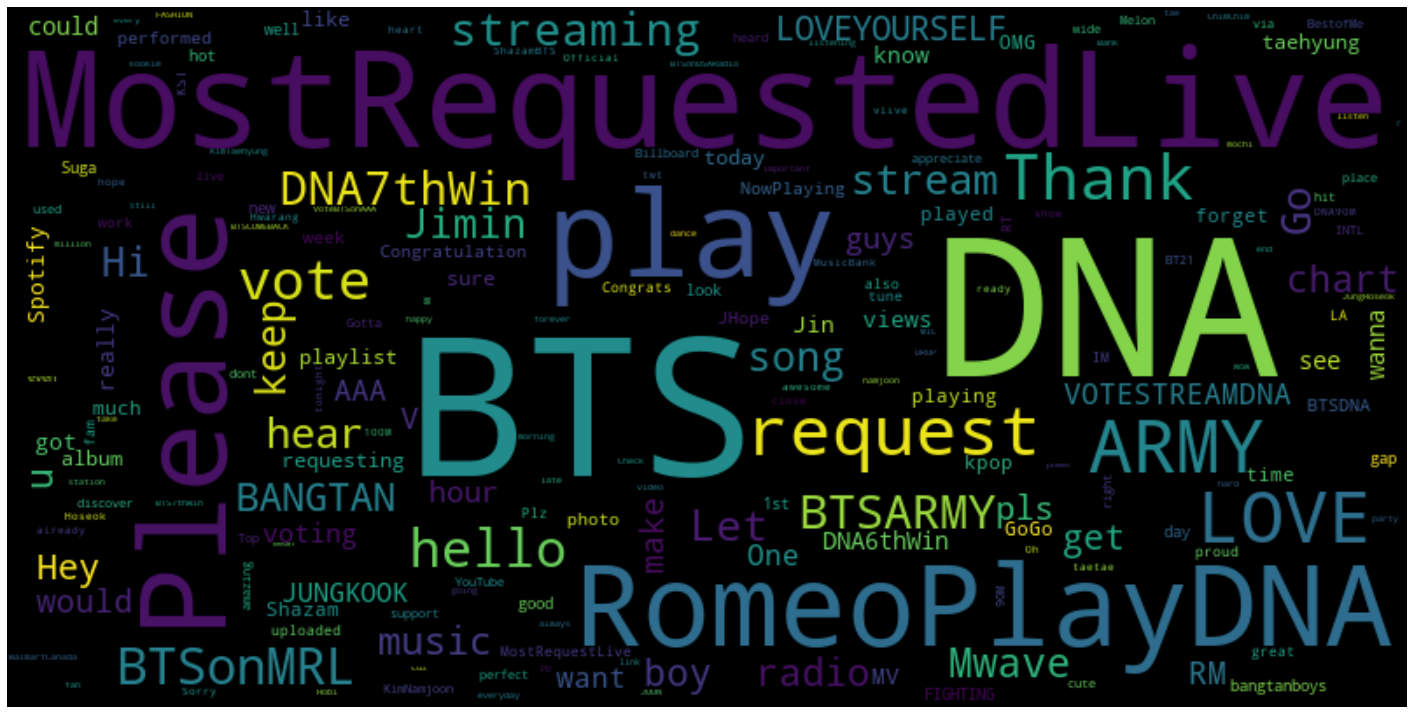

In [128]:
#plotting wordcloud from tweets

words_w2 = ' '.join( [tweets for tweets in df_week2["text"]] )
wordcloud_w2 = WordCloud(width = 800, height = 400, random_state = 10, 
                         max_font_size=110, collocations = False, 
                         stopwords = stop_words).generate(words_w2)
plt.figure( figsize = (20,10) )
plt.imshow(wordcloud_w2, interpolation='bilinear')
plt.tight_layout(pad = 0)
plt.axis("off")
plt.show()

### LDA - Topic Modelling

#### Preprocessing for LDA

In [51]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))

w2_words = list(sent_to_words(df_week2["text"]))

stop_words = stopwords.words('english')

# Build bigram and trigram models

bigram = gensim.models.Phrases(w2_words, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[w2_words], threshold = 100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(text):
  return [bigram_mod[doc] for doc in text]

def make_trigram(text):
  return [trigram_mod[bigram_mod[doc]] for doc in text]

w2_clean_words = remove_stopwords(w2_words)
w2_bigram = make_bigrams(w2_clean_words)

#Create Dictionary and Corpus

id2word_w2 = corpora.Dictionary(w2_bigram)
texts_w2 = w2_bigram
corpus_w2 = [id2word_w2.doc2bow(text) for text in texts_w2]

#### LDA base model

In [97]:
#LDA model training 

LDA = gensim.models.ldamodel.LdaModel
lda_w2 = LDA(corpus=corpus_w2,
             id2word = id2word_w2,
             num_topics = 10,
             per_word_topics = True,
             passes = 1,
             eval_every = None)


# Perplexity Score - Lower the Better
print('Perplexity Score: ', round(lda_w2.log_perplexity(corpus_w2), 3))

#Computing Coherence Score - Higher, More Human Interpretable
coherence_model_lda = CoherenceModel(model = lda_w2,
                              texts = w2_bigram,
                              dictionary = id2word_w2,
                              coherence='c_v')

coherence_w2 = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_w2, 3))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Perplexity Score:  -5.327
Coherence Score:  0.404


 For this base model, 
<br> Perplexity Score is -5.327
<br> Coherence Score: 0.404

#### Finding Best Parameters

In [98]:
# Hyperparameter Tuning
# Grid Search
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(df_week2['lemmas_to_text'])

search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid = search_params)

model.fit(data_vectorized)
GridSearchCV(cv = None, error_score = 'raise',
             estimator = LatentDirichletAllocation(batch_size = 128,
                                                   doc_topic_prior = None,
                                                   evaluate_every = -1,
                                                   learning_decay = 0.7,
                                                   learning_method = None,
                                                   learning_offset = 10.0,
                                                   max_doc_update_iter = 100,
                                                   max_iter = 10,
                                                   mean_change_tol = 0.001,
                                                   n_components = 10,
                                                   n_jobs = 1,
                                                   perp_tol = 0.1,
                                                   random_state = None,
                                                   topic_word_prior = None,
                                                   total_samples = 1000000.0,
                                                   verbose = 0),
             n_jobs = 1,
             param_grid = {'n_topics' : [10, 15, 20, 30],
                           'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch = '2*n_jobs', refit = True, return_train_score = 'warn',
             scoring = None, verbose = 0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             n_jobs=1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_topics': [10, 15, 20, 30]},
             return_train_score='warn')

In [99]:
best_lda = model.best_estimator_

#Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -14397.320632956104
Model Perplexity:  180.3611729786382


In [ ]:
#Defining function to loop over number of topics to be used to find an
#optimal number of topics

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
  coherence_values_topic = []
  model_list_topic = []
  for num_topics in range(start, limit, step):
    model = LdaMulticore(corpus=corpus, num_topics = num_topics, id2word = id2word_w2)
    model_list_topic.append(model)
    coherencemodel = CoherenceModel(model=model, texts = texts, dictionary=dictionary, coherence = 'c_v')
    coherence_values_topic.append(coherencemodel.get_coherence())
  
  return model_list_topic, coherence_values_topic

model_list_topic, coherence_values_topic = compute_coherence_values(dictionary = id2word_w2,
                                                                    corpus = corpus_w2,
                                                                    texts = w2_bigram,
                                                                    start = 2, limit = 200, step = 6)

In [101]:
print(len(coherence_values_topic))
print(len(model_list_topic))

# From this, we can estimate that with 33 topics, the model can bring the most optimal result

33
33


#### Final LDA model

In [ ]:
# Final model

lda_model_w2 = LdaMulticore(corpus = corpus_w2,
                            id2word = id2word_w2,
                            num_topics = 33,
                            decay = 0.9)

In [103]:
lda_model_w2.print_topics()

[(8,
  '0.118*"bts" + 0.118*"dna" + 0.088*"play" + 0.079*"please" + 0.069*"romeoplaydna" + 0.020*"hello" + 0.010*"hey" + 0.010*"jimin" + 0.010*"aaadna" + 0.010*"seokjin"'),
 (20,
  '0.147*"dna" + 0.103*"bts" + 0.030*"play" + 0.027*"please" + 0.023*"romeoplaydna" + 0.023*"thwin" + 0.014*"streaming" + 0.013*"loveyourself" + 0.012*"performed" + 0.012*"keep"'),
 (30,
  '0.155*"bts" + 0.145*"dna" + 0.072*"play" + 0.067*"romeoplaydna" + 0.067*"please" + 0.022*"hello" + 0.019*"thank" + 0.015*"btsonmrl" + 0.010*"vote" + 0.010*"mv"'),
 (16,
  '0.139*"dna" + 0.135*"bts" + 0.060*"please" + 0.060*"play" + 0.022*"thwin" + 0.020*"romeoplaydna" + 0.017*"hear" + 0.011*"go" + 0.011*"love" + 0.008*"army"'),
 (19,
  '0.116*"dna" + 0.105*"bts" + 0.030*"romeoplaydna" + 0.027*"love" + 0.020*"play" + 0.020*"army" + 0.015*"please" + 0.010*"ph" + 0.010*"btsonmrl" + 0.010*"btsdna"'),
 (7,
  '0.103*"bts" + 0.098*"dna" + 0.053*"romeoplaydna" + 0.037*"please" + 0.037*"play" + 0.030*"request" + 0.019*"jimin" + 0.01

In [104]:
print(round(lda_model_w2.log_perplexity(corpus_w2), 3))
coherence_model_lda = CoherenceModel(model = lda_model_w2,
                              texts = texts_w2,
                              dictionary = id2word_w2,
                              coherence='c_v')

print(round(coherence_model_lda.get_coherence(), 3))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

-5.737
0.42


The final model of lda gives following result:
<br> perplexity score: -5.737
<br> coherence score: 0.42

In [105]:
# Visualiation

vis = pyLDAvis.gensim_models.prepare(lda_model_w2, corpus_w2, id2word_w2)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.155435 -0.045771       1        1  21.794231
11     0.107456  0.012778       2        1   7.504362
26     0.025050  0.116789       3        1   5.693213
31     0.058294 -0.054161       4        1   4.474882
25    -0.041139  0.084076       5        1   3.482881
12     0.113152 -0.016372       6        1   3.461647
22     0.068062  0.032097       7        1   3.410020
20     0.013780  0.053310       8        1   3.361348
4      0.089758 -0.018821       9        1   3.312447
14     0.063712  0.015012      10        1   3.136567
9      0.083137  0.024042      11        1   3.051574
6     -0.030511  0.150055      12        1   3.037002
17     0.020517  0.054067      13        1   2.877531
30     0.086921 -0.036551      14        1   2.869160
28     0.087255 -0.039005      15        1   2.515857
16     0.049778  0.050677      16        1   2.362519
2      0.041254  0.004381      17        1   2.361056
7      0.017962 -0.046908      18        1   2.284076
13    -0.084021  0.036227      19        1   2.122493
19    -0.018230  0.036087      20        1   2.011590
5      0.025586 -0.018682      21        1   2.003714
1      0.047564 -0.070168      22        1   1.673376
32    -0.048253 -0.082521      23        1   1.653985
0      0.016404 -0.018920      24        1   1.493648
3     -0.139101 -0.001383      25        1   1.310046
24    -0.095984 -0.048192      26        1   1.274290
27    -0.021024 -0.006154      27        1   1.216126
21    -0.057726  0.016634      28        1   1.102864
23    -0.071571 -0.052638      29        1   0.740866
10    -0.124118 -0.043984      30        1   0.687199
29    -0.174916  0.012344      31        1   0.607167
8      0.005486 -0.067057      32        1   0.586855
18    -0.269966 -0.031289      33        1   0.525407, topic_info=            Term        Freq       Total Category  logprob  loglift
0            bts  944.000000  944.000000  Default  30.0000  30.0000
1            dna  993.000000  993.000000  Default  29.0000  29.0000
13          play  415.000000  415.000000  Default  28.0000  28.0000
14        please  406.000000  406.000000  Default  27.0000  27.0000
4   romeoplaydna  387.000000  387.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
16      btsonmrl    0.026404   55.106605  Topic33  -7.2436  -2.3948
17          keep    0.026404   25.929554  Topic33  -7.2436  -1.6409
18    requesting    0.026404    8.550140  Topic33  -7.2436  -0.5314
19         armys    0.026404   14.611533  Topic33  -7.2436  -1.0673
20          love    0.026404   91.512750  Topic33  -7.2436  -2.9020

[1743 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
191       3  0.133276    aaa
191       4  0.133276    aaa
191       5  0.199914    aaa
191       6  0.066638    aaa
191       9  0.066638    aaa
...     ...       ...    ...
378      27  0.696792  youre
624       8  0.565071   youu
371       6  0.678424    ypu
196      24  0.701260     yt
421      12  0.546840    yuk

[2301 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 12, 27, 32, 26, 13, 23, 21, 5, 15, 10, 7, 18, 31, 29, 17, 3, 8, 14, 20, 6, 2, 33, 1, 4, 25, 28, 22, 24, 11, 30, 9, 19])

## Plotting

In [38]:
# Number of Unique Users:
num_unique_users = [num_unique_users_wb, num_unique_users_w, num_unique_users_w1, num_unique_users_w2]
timeframe = ['Week Before', 'Week', 'Week After', '2 Weeks After']
df_unique_users = pd.DataFrame({'Number of Unique Users': num_unique_users}, index = timeframe)
df_unique_users

Number of Unique Users
Week Before                       603
Week                              682
Week After                        464
2 Weeks After                     608

In [39]:
num_positive_twts = [positiveTweets_wb_pct, positiveTweets_w_pct, positiveTweets_w1_pct, positiveTweets_w2_pct]
num_negative_twts = [negativeTweets_wb_pct, negativeTweets_w_pct, negativeTweets_w1_pct, negativeTweets_w2_pct]
num_neutral_twts = [neutralTweets_wb_pct, neutralTweets_w_pct, neutralTweets_w1_pct, neutralTweets_w2_pct]

df_sentiment = pd.DataFrame({'Timeframe': timeframe,
                             'Percentage of Positive Tweets': num_positive_twts, 
                            'Percentage of Negative Tweets': num_negative_twts, 
                            'Percentage of Neutral Tweets': num_neutral_twts})
df_sentiment

Timeframe  Percentage of Positive Tweets  \
0    Week Before                           65.3   
1           Week                           60.0   
2     Week After                           59.4   
3  2 Weeks After                           69.8   

   Percentage of Negative Tweets  Percentage of Neutral Tweets  
0                           16.1                          18.6  
1                            8.9                          31.1  
2                            8.8                          31.8  
3                            3.0                          27.2

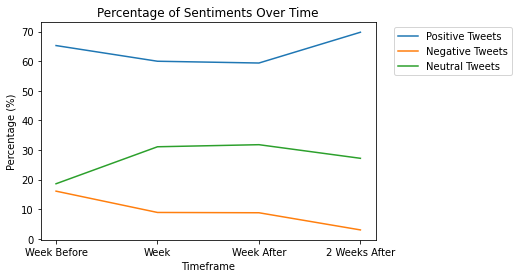

In [40]:
plt.plot(timeframe, num_positive_twts, label = "Positive Tweets")
plt.plot(timeframe, num_negative_twts, label = "Negative Tweets")
plt.plot(timeframe, num_neutral_twts, label = "Neutral Tweets")
plt.legend()
plt.legend(bbox_to_anchor=(1.04, 1), loc = "upper left")
plt.title("Percentage of Sentiments Over Time")
plt.ylabel("Percentage (%)")
plt.xlabel("Timeframe")
plt.show()

In [59]:
dict_wb = len(id2word_wb)
dict_w = len(id2word_w)
dict_w1 = len(id2word_w1)
dict_w2 = len(id2word_w2)

In [60]:
len_dictionary = [dict_wb, dict_w, dict_w1, dict_w2]
df_dict = pd.DataFrame({'Size of Dictionary': len_dictionary}, index = timeframe)
df_dict

Size of Dictionary
Week Before                  1615
Week                         1863
Week After                   1616
2 Weeks After                1125

In [149]:
top_words_per_topic = []
for t in range(lda_model_wb.num_topics):
  top_words_per_topic.extend([(t, ) + x for x in lda_model_wb.show_topic(t, topn = 1)])

pd.DataFrame(top_words_per_topic, columns = ['Topic', 'Word', 'P']).T

0         1         2         3         4         5         6   \
Topic        0         1         2         3         4         5         6   
Word       bts       dna       bts       dna       dna       dna       dna   
P      0.07742  0.111692  0.118578  0.061913  0.113709  0.105201  0.099283   

             7        8         9   ...        23        24        25  \
Topic         7        8         9  ...        23        24        25   
Word        bts      bts       bts  ...       bts       dna       bts   
P      0.137728  0.10463  0.094379  ...  0.111624  0.108641  0.108171   

             26        27        28        29        30        31        32  
Topic        26        27        28        29        30        31        32  
Word        bts       bts       dna      dont       dna       dna       dna  
P      0.104799  0.119093  0.035216  0.040182  0.120786  0.230405  0.071746  

[3 rows x 33 columns]

In [147]:
top_words_per_topic = []
for t in range(lda_model_w.num_topics):
  top_words_per_topic.extend([(t, ) + x for x in lda_model_w.show_topic(t, topn = 1)])

pd.DataFrame(top_words_per_topic, columns = ['Topic', 'Word', 'P']).T

0         1        2         3         4         5         6   \
Topic         0         1        2         3         4         5         6   
Word        bts       dna      bts       bts       bts       bts       dna   
P      0.101501  0.092177  0.11901  0.051782  0.150907  0.078271  0.129387   

             7         8         9   ...        23        24        25  \
Topic         7         8         9  ...        23        24        25   
Word        bts       bts       dna  ...       bts       bts       bts   
P      0.133998  0.078483  0.138952  ...  0.133167  0.113932  0.110155   

            26        27       28        29        30        31        32  
Topic       26        27       28        29        30        31        32  
Word       bts       dna      bts       dna       bts       bts       dna  
P      0.15211  0.104487  0.13219  0.042348  0.100079  0.106464  0.085166  

[3 rows x 33 columns]

In [148]:
top_words_per_topic = []
for t in range(lda_model_w1.num_topics):
  top_words_per_topic.extend([(t, ) + x for x in lda_model_w1.show_topic(t, topn = 1)])

pd.DataFrame(top_words_per_topic, columns = ['Topic', 'Word', 'P']).T

0         1         2         3         4         5         6   \
Topic         0         1         2         3         4         5         6   
Word        dna       dna       dna       dna       bts       dna       dna   
P      0.129676  0.161409  0.129309  0.131596  0.031374  0.045815  0.156332   

             7         8         9   ...        23        24        25  \
Topic         7         8         9  ...        23        24        25   
Word        bts       dna       dna  ...       dna       bts       bts   
P      0.072681  0.168674  0.129068  ...  0.111291  0.028211  0.119079   

            26        27        28        29        30        31        32  
Topic       26        27        28        29        30        31        32  
Word       dna       dna       dna       dna       dna       dna       bts  
P      0.11198  0.050088  0.096025  0.123377  0.120022  0.114709  0.098395  

[3 rows x 33 columns]

In [170]:
top_words_per_topic = []
for t in range(lda_model_w2.num_topics):
  top_words_per_topic.extend([(t, ) + x for x in lda_model_w2.show_topic(t, topn = 1)])

pd.DataFrame(top_words_per_topic, columns = ['Topic', 'Word', 'P']).T

0         1         2         3         4         5         6   \
Topic         0         1         2         3         4         5         6   
Word        bts       dna       dna       bts       bts       bts       dna   
P      0.114024  0.133873  0.144965  0.079251  0.148099  0.126894  0.142915   

             7         8         9   ...        23        24        25  \
Topic         7         8         9  ...        23        24        25   
Word        bts       bts       dna  ...       bts       bts       dna   
P      0.102869  0.117839  0.153445  ...  0.080307  0.081572  0.107461   

             26        27        28       29        30        31        32  
Topic        26        27        28       29        30        31        32  
Word        bts       bts       bts      bts       bts       bts       dna  
P      0.135267  0.125249  0.141176  0.07451  0.154641  0.151259  0.080562  

[3 rows x 33 columns]